# Import Libraries and Read Data

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
import os

In [172]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/

import csv
with open("Modified.csv", 'r') as file:
    csvreader = csv.reader(file)
    column_names = next(csvreader)
    
print(column_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
['gen_cat', 'Hypertension_cat', 'IHD_cat', 'insulin_treatment_cat', 'fam_his_diab_cat', 'bp_sys', 'Physical_AS_cat', 'ann_family_in', 'HbA1c_grade_cat', 'agegrp_cat', 'BMIcat', 'DurYrs', 'FBS_Grp_cat', 'DR']


In [173]:
dataset = pd.read_csv("Modified.csv")
dataset.head(5)

,gen_cat,Hypertension_cat,IHD_cat,insulin_treatment_cat,fam_his_diab_cat,bp_sys,Physical_AS_cat,ann_family_in,HbA1c_grade_cat,agegrp_cat,BMIcat,DurYrs,FBS_Grp_cat,DR
0,1,0,1,1,1,160,0,24000,2,2,0,22.0,1,0
1,1,1,1,1,0,140,1,24000,1,0,1,0.0,1,0
2,1,1,1,1,0,154,0,24000,0,3,1,2.0,0,0
3,0,1,1,1,0,130,0,180000,3,0,1,8.0,1,0
4,0,0,1,1,0,140,0,18000,4,2,2,6.0,1,0


# Autoencoder Hyperparameters!

In [174]:
# 13 without DR and 13 with DR
inout_dims = 14
latent_dim = 7

In [175]:
if(inout_dims == 13):
  X = dataset.iloc[:, :-1].values
else:
  X = dataset.iloc[:, :].values

# Train Test Split and Feature Scaling

### Old Scaler

In [176]:
X_train, X_test = train_test_split(X, test_size = 0.3, random_state = 0)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# # Get Values between 0 and 1 for the Autoencoder


# sc = Normalizer() 
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

### New Continuous Scaler

In [177]:
continuous_cols = []
categorical_cols = []
for i in range(0,X.shape[1]):
  
  if dataset.columns[i].find("cat")!=-1:
    categorical_cols.append(i)
  else:
    continuous_cols.append(i)

print(dataset.columns[continuous_cols])
print(dataset.columns[categorical_cols])

Index(['bp_sys', 'ann_family_in', 'DurYrs', 'DR'], dtype='object')
Index(['gen_cat', 'Hypertension_cat', 'IHD_cat', 'insulin_treatment_cat',
       'fam_his_diab_cat', 'Physical_AS_cat', 'HbA1c_grade_cat', 'agegrp_cat',
       'BMIcat', 'FBS_Grp_cat'],
      dtype='object')


In [178]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train[:,continuous_cols])
X_train = np.concatenate((X_tr,X_train[:,categorical_cols]),axis=1)
X_te = scaler.transform(X_test[:,continuous_cols])
X_test = np.concatenate((X_te,X_test[:,categorical_cols]),axis=1)

In [179]:
print(X_train.shape)
print(X_test.shape)

(1088, 14)
(467, 14)


In [180]:
print(X_test)

[[ 5.64796339e-01 -3.80842699e-01  2.45292950e+00 ...  2.00000000e+00
   2.00000000e+00  1.00000000e+00]
 [-1.41267242e+00  2.83620758e-01  1.63367745e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 7.04291493e-02  2.83620758e-01 -8.24078714e-01 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 ...
 [-1.90703961e+00 -4.31955272e-01  3.22874162e-01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [-9.18305230e-01  8.46163253e+00 -4.82665962e-03 ...  2.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 5.64796339e-01 -5.34180419e-01 -4.96377892e-01 ...  2.00000000e+00
   1.00000000e+00  0.00000000e+00]]


# Dimensionality Reduction with Autoencoders

In [181]:
import os
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Single-Layer Autoencoder with ReLU activation

In [182]:
class Autoencoder(Model):
  def __init__(self, latent_dim, inout_dims):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential(
        [
         layers.InputLayer(input_shape=(inout_dims,)),
         layers.Dense(latent_dim, activation = 'relu') # latent_dim is 7
       ], name = 'Code_Layer'
    )

    self.decoder = tf.keras.Sequential(
        [
         layers.Dense(inout_dims, activation = 'relu')
       ], name = 'Output_Layer'
    )

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim = latent_dim, inout_dims = inout_dims)

autoencoder.compile(optimizer = 'adam', loss = losses.MeanAbsoluteError())


# Save Weights on a Good Result

## Training

In [183]:
!cd K:

/bin/bash: line 0: cd: K:: No such file or directory


In [184]:
checkpoint_path = "Autoencoder_weights/cp.ckpt"
#checkpoint_path = "K:/My Drive/Autoencoder_weights/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = autoencoder.fit(X_train, X_train, epochs = 15, validation_data = (X_test, X_test))

autoencoder.summary()

Epoch 1/15
34/34 [==============================] - 1s 7ms/step - loss: 0.8422 - val_loss: 0.8159
Epoch 2/15
34/34 [==============================] - 0s 3ms/step - loss: 0.7887 - val_loss: 0.7719
Epoch 3/15
34/34 [==============================] - 0s 3ms/step - loss: 0.7458 - val_loss: 0.7353
Epoch 4/15
34/34 [==============================] - 0s 4ms/step - loss: 0.7129 - val_loss: 0.7131
Epoch 5/15
34/34 [==============================] - 0s 4ms/step - loss: 0.6956 - val_loss: 0.7011
Epoch 6/15
34/34 [==============================] - 0s 4ms/step - loss: 0.6824 - val_loss: 0.6847
Epoch 7/15
34/34 [==============================] - 0s 3ms/step - loss: 0.6467 - val_loss: 0.6389
Epoch 8/15
34/34 [==============================] - 0s 3ms/step - loss: 0.6117 - val_loss: 0.6223
Epoch 9/15
34/34 [==============================] - 0s 3ms/step - loss: 0.5987 - val_loss: 0.6117
Epoch 10/15
34/34 [==============================] - 0s 3ms/step - loss: 0.5834 - val_loss: 0.5904
Epoch 11/15
34/34 [

In [185]:
os.listdir(checkpoint_dir)

[]

# Score Features by weights learned by the Code Layer

In [186]:
encoder_layer = autoencoder.get_layer('Code_Layer')
print(encoder_layer.input_shape)
print(encoder_layer.output_shape)

(None, 14)
(None, 7)


In [187]:
# Just Sum across the rows and get the score_weights for each feature!!
score_weights = []
weights, bias = encoder_layer.get_weights()  # Gives the weights (7, 13) AND bias (7, 1) !!

# print(weights.shape)
print("WEIGHTS:")
print(weights)

print()
score_weights = np.sum(weights, axis = 1)
print("SCORE_WEIGHTS:")
print(score_weights)

WEIGHTS:
[[-0.04211265 -0.21287672 -0.26577607 -0.27709788 -0.02921104  0.10187366
  -0.11471162]
 [-0.03443978 -0.08403156 -0.24779265  0.11259139 -0.28032076 -0.0311311
  -0.04591008]
 [-0.20437436  0.29625994 -0.12092841 -0.2167179  -0.18368562  0.08865235
   0.02891091]
 [-0.53807735 -0.16868266  0.33417395  0.14266333  0.24348475  0.22191325
   0.22833264]
 [-0.12457169 -0.32943642 -0.45998505  0.2870218   0.1159327   0.19706781
  -0.02879311]
 [ 0.06159458 -0.12556297  0.299098    0.08915604 -0.0065519   0.436471
   0.28824922]
 [ 0.43896925 -0.4099379   0.0559241   0.32263008  0.26785016  0.32155564
  -0.20308065]
 [ 0.3130726  -0.31802762 -0.41887468 -0.34151506  0.391004    0.45281503
   0.17556351]
 [ 0.04243265 -0.36396527 -0.43080473  0.2685622   0.75331146 -0.06384856
   0.5759698 ]
 [ 0.2664344  -0.36622894  0.2956593  -0.6389846   0.38799697  0.11488265
   0.00784941]
 [-0.22330987 -0.09737973 -0.283811    0.12372562 -0.08114727  0.924636
  -0.25156066]
 [ 0.34000397  0.

# Sort Results and Categorize by Threshold

In [188]:
# score_weights = np.zeros(13)
column_names = np.array(column_names)
names = column_names[:-1]
score_weights = np.array(score_weights)

if(inout_dims == 13):
  name_array = names
else:
  name_array = column_names


comb = np.concatenate((name_array.reshape(len(name_array),1), score_weights.reshape(len(score_weights),1)),1)


In [189]:
import math

In [190]:
sorted = comb[comb[:,1].argsort()]
#print(sorted)
#print()

median = math.floor(sorted.shape[0]/2) # Index of median element
threshold = sorted[median][1]
print("Threshold is ", threshold)
# threshold = float(threshold)
# print(type(threshold))


def assign_class_labels(comb):
  labeled = comb
  i = 0
  #print("Predicted Risk Factor Labels:")
  for pair in comb:
    if pair[1] <= threshold:
      labeled[i][1] = 2
      #print("Secondary: ",pair[0])
    else:      
      labeled[i][1] = 1
      #print("Primary: ", pair[0])

    i = i+1

  print()
  return labeled


lab = assign_class_labels(comb)
#print(lab)

Threshold is  0.11115304



# Evaluate Risk Factor Clustering

In [191]:
from prettytable import PrettyTable

In [192]:
gold_truth = [['gen_cat', 2],
 ['Hypertension_cat', 1],
 ['IHD_cat', 2],
 ['insulin_treatment_cat', 1],
 ['fam_his_diab_cat', 2],
 ['bp_sys', 1],
 ['Physical_AS_cat', 2],
 ['ann_family_in', 2],
 ['HbA1c_grade_cat', 1],
 ['agegrp_cat', 2],
 ['BMIcat', 2],
 ['DurYrs', 1],
 ['FBS_Grp_cat', 1]]


In [193]:
def confusion(labeled, gold_truth):
  i = 0
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  wrong_features = []

  for pairs in  gold_truth:
    a = labeled[i][1].astype(int) # Predicted
    b = np.int64(pairs[1]) # Actual
    
    if (a == 1 and b==1):
      tp = tp+1
    elif(a==2 and b==2):
      tn = tn+1
    elif(a==1 and b==2):
      fp = fp+1
      wrong_features.append([pairs[0], i])
    elif (a==2 and b==1):
      fn = fn + 1
      wrong_features.append([pairs[0], i])
    
    i = i+1

  table = PrettyTable(['', 'Actual Primary', 'Actual Secondary'])
  table.add_row(['Predicted Primary', tp, fp])
  table.add_row(['Predicted Secondary', fn, tn])
  return table, tp, tn, fp, fn, wrong_features



In [194]:
def comparison_table(lab, gold_truth):
  table = PrettyTable(['Risk Factor', 'Actual', 'Predicted', 'Correctness'])
  i = 0
  for pairs in  gold_truth:
    a = lab[i][1].astype(int)
    b = np.int64(pairs[1])
    correct = "Correct" if a==b else "Wrong"
    table.add_row([pairs[0], b, a, correct])
    i = i+1

  confusion_mat, tp, tn, fp, fn, wrongs = confusion(lab, gold_truth)
  print("Comparison Table:")
  print(table)

  print("Wrongly Classified Features:")
  # print(wrongs)
  [print('  ',thing) for thing, i in wrongs]
  print()

  print("Confusion Matrix:")
  print(confusion_mat)
  
  return tp, tn, fp, fn, wrongs 

In [195]:
tp, tn, fp, fn, wrongs = comparison_table(lab, gold_truth)
print("Features in Correct clusters = ", tp+tn)
print("Features in Wrong clusters = ", fp+fn)

Comparison Table:
+-----------------------+--------+-----------+-------------+
|      Risk Factor      | Actual | Predicted | Correctness |
+-----------------------+--------+-----------+-------------+
|        gen_cat        |   2    |     2     |   Correct   |
|    Hypertension_cat   |   1    |     2     |    Wrong    |
|        IHD_cat        |   2    |     2     |   Correct   |
| insulin_treatment_cat |   1    |     1     |   Correct   |
|    fam_his_diab_cat   |   2    |     2     |   Correct   |
|         bp_sys        |   1    |     1     |   Correct   |
|    Physical_AS_cat    |   2    |     1     |    Wrong    |
|     ann_family_in     |   2    |     1     |    Wrong    |
|    HbA1c_grade_cat    |   1    |     1     |   Correct   |
|       agegrp_cat      |   2    |     2     |   Correct   |
|         BMIcat        |   2    |     2     |   Correct   |
|         DurYrs        |   1    |     2     |    Wrong    |
|      FBS_Grp_cat      |   1    |     1     |   Correct   |
+-----

# Visualize Results

In [196]:
import statistics
threshold = statistics.median(score_weights)
print(threshold)

0.08938110619783401


In [197]:

colors = []

for i in range(inout_dims):
  if(score_weights[i]>=threshold):
  # Primary
    colors.append('hotpink') 
  else:
  # Secondary
    colors.append('navy')

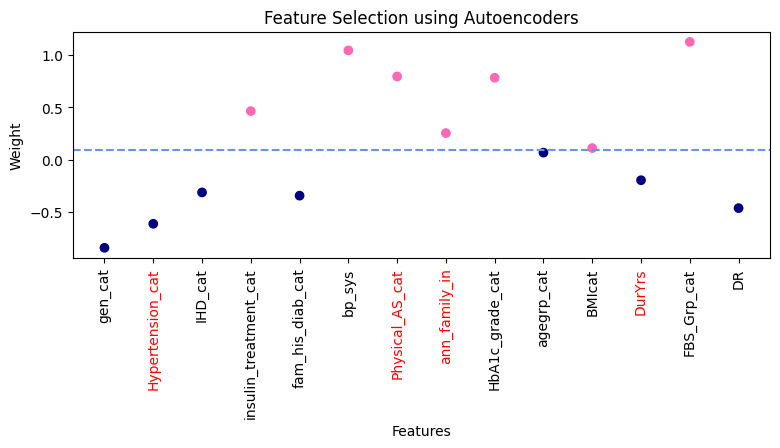

In [198]:
y_pos = np.arange(inout_dims)
labels = column_names


plt.figure(figsize=(9,3),dpi=100)

# plt.scatter(y_pos, sorted[:,1])
plt.scatter(y_pos, score_weights, c = colors)

plt.axhline(y=threshold, color='cornflowerblue', linestyle='--')

plt.title("Feature Selection using Autoencoders")
plt.xlabel("Features")
plt.ylabel("Weight")

plt.xticks(y_pos, labels, rotation = 90)
for label, index in wrongs:
  plt.gca().get_xticklabels()[index].set_color('red')

plt.show()